In [1]:
import data
import seaborn as sns
import numpy as np
import pandas as pd
import patsy
%matplotlib inline

/home/jacquelineburos/projects/immune-infiltrate-explorations/.env/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import pystan
import stanity

In [3]:
sns.set(context='talk')

## load files for all cell types

In [4]:
# list types of cells
subsets = data.prep_filename_metadata()
subsets['SubSet'].unique()
all_types = list(subsets['SubSet'].unique())
print(all_types)

['CD4_Th2', 'CD8_Effector', 'B_CD5', 'B_Memory', 'CD4_Th1', 'CD4_Naive', 'B_Naive', 'CD4_Effector_Memory', 'CD8_Central_Memory', 'CD4_Central_Memory', 'CD4_Treg', 'CD8_Naive', 'CD4_Th17']


In [5]:
df = data.load_by_cell_type(all_types, metadata=subsets)

In [6]:
df = data.prep_annotated_data(df)

In [7]:
assert all(pd.notnull(df['log1p_tpm_rescaled']))

## prep gene ids

For model-estimation, we first need to map each gene_name to a numeric ID. 


In [8]:
df['gene_cat'] = df['gene_name'].astype('category')
df['gene_id'] = df['gene_cat'].cat.codes+1

In [9]:
df['B_cell'] = df['cell_type'].apply(lambda x: 1 if x == 'B' else 0)
df['T_cell'] = df['cell_type'].apply(lambda x: 1 if x != 'B' else 0)

In [10]:
df.head()

,sample_id,filename,gene_name,est_counts,tpm,log1p_tpm,log1p_counts,CCR6,CCR7,CD127,...,CXCR3,SubSet,cell_type,log1p_tpm_rescaled_type,log1p_tpm_rescaled_subset,log1p_tpm_rescaled,gene_cat,gene_id,B_cell,T_cell
0,1,ERR431566,A1BG,56.743290,6.931783,2.070878,4.056007,None,None,None,...,,CD4_Th2,CD4,-5.599303,-3.517738,-5.478180,A1BG,1,0,1
1,1,ERR431566,A1CF,5.194920,0.111335,0.105562,1.823730,None,None,None,...,,CD4_Th2,CD4,-1.164584,-1.529020,-0.735391,A1CF,2,0,1
2,1,ERR431566,A2M,10.000009,3.877857,1.584706,2.397896,None,None,None,...,,CD4_Th2,CD4,1.338389,-0.920287,1.188265,A2M,3,0,1
3,1,ERR431566,A2ML1,9.387660,1.860813,1.051106,2.340619,None,None,None,...,,CD4_Th2,CD4,1.092135,1.947468,0.895292,A2ML1,4,0,1
4,1,ERR431566,A2MP1,31.000030,3.441394,1.490968,3.465737,None,None,None,...,,CD4_Th2,CD4,1.945796,4.135726,1.532385,A2MP1,5,0,1


## run model for all genes

In [16]:
sample_df = data.prep_sample_df(df, sample_n=None)

## fit model at level of cell-type

In [17]:

def prep_stan_data(sample_df):
    stan_data = {'N': len(sample_df.index),
             'G': len(sample_df.new_gene_id.unique()),
             'S': len(sample_df.new_sample_id.unique()),
             'C': 2,
             'gene': sample_df.new_gene_id.values,
             'sample': sample_df.new_sample_id.values,
             'x': patsy.dmatrix('0 + B_cell + T_cell', data=sample_df, return_type='dataframe'),
             'y': sample_df.est_counts.astype(int).values,
            }
    return stan_data


In [18]:
stan_data = prep_stan_data(sample_df)

In [19]:
## try neg binom parameterization
stan_code4 = '''
data {
    // dimensions
    int<lower=1> N;  // N obs
    int<lower=1> G;  // N genes
    int<lower=1> S;  // N samples
    int<lower=0> C;  // N classes (e.g. B-cell, T-cell, B_Naive, CD5, CD45RO, etc)
                     // note: classes should be mutually exclusive. Each row here should sum to 1
   
    // data
    int<lower=1, upper=G> gene[N];    // gene id for each obs
    int<lower=1, upper=S> sample[N];  // sample id for each obs
    vector<lower=0, upper=1>[C] x[N]; // map each obs to each class (0:'- or ?', 1:'+')
    int<lower=0> y[N];                // count/tpm for each obs
}
transformed data {
    int sample_y[S, G]; // array (size SxG) of ints
    vector[C] sample_x[S]; // array (size S) of vectors[C]
    for (n in 1:N) {
        sample_y[sample[n], gene[n]] = y[n];
        sample_x[sample[n]] = x[n,];
    }
}
parameters {
    matrix<lower=0>[G, C] theta; // loading factors for each gene, for each cell type
    vector[G] log_gene_base;     // constant intercept expression level for each gene, irrespective of cell type
    vector<lower=0>[G] gene_phi;          // overdispersion parameter per transcript (for now)
}
model {
    for (i in 1:G)
        theta[i] ~ normal(0, 1);
    log_gene_base ~ normal(0, 1);
    gene_phi ~ normal(0, 1);
    for (s in 1:S) {
        vector[G] log_expected_rate;
        log_expected_rate = log_gene_base + log(theta*sample_x[s]);
        sample_y[s] ~ neg_binomial_2_log(log_expected_rate, gene_phi);
    }
}
generated quantities {
    int y_rep[N];
    real log_lik[N];
    
    for (n in 1:N) {
        real log_expected_rate;
        log_expected_rate = log_gene_base[gene[n]] + log(theta[gene[n], ]*x[n]);
        y_rep[n] = neg_binomial_2_log_rng(log_expected_rate, gene_phi[gene[n]]);
        log_lik[n] = neg_binomial_2_log_lpmf(y[n] | log_expected_rate, gene_phi[gene[n]]);
    }
}
'''

In [ ]:
fit4 = data.cached_stan_fit(model_code=stan_code4, data=stan_data, iter=500, chains=4)

Reusing model.


In [ ]:
data.print_stan_summary(fit4, pars='theta')

In [ ]:
theta_ldf = data.prep_theta_summary(fit4, sample_df=sample_df, expose_group='T_cell')

In [ ]:
g = sns.boxplot(data=theta_ldf.sort_values('T_cell_mean'),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, width=2, linewidth=0.2)

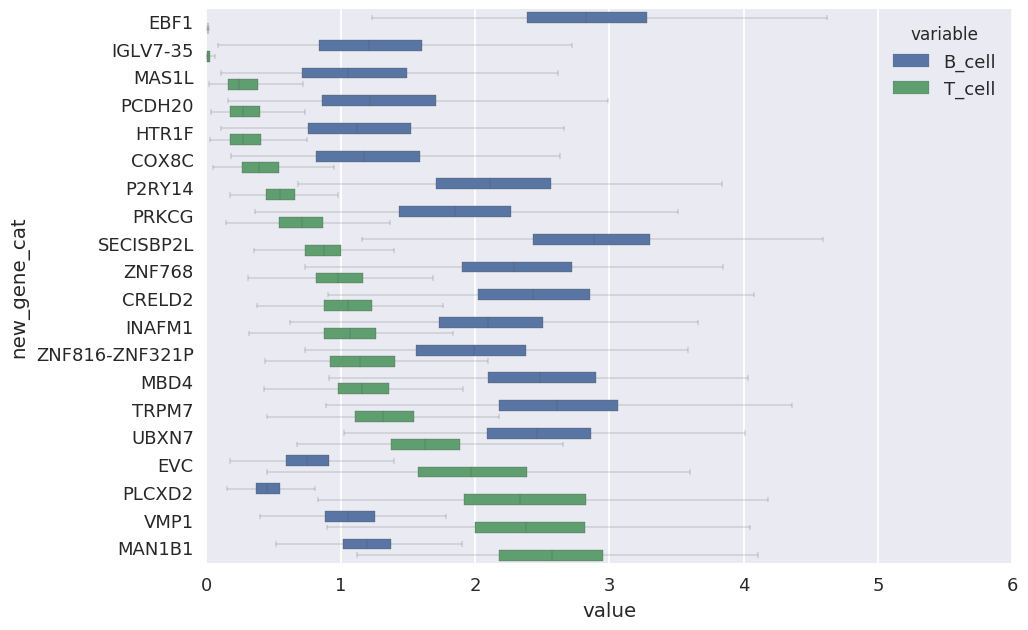

In [141]:
g = sns.boxplot(data=theta_ldf.query('abs(mean_diff)>0.4').sort_values(['T_cell_mean']),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, linewidth=0.2)


In [150]:
yrep_df = data.prep_yrep_summary(fit4, sample_df=sample_df)

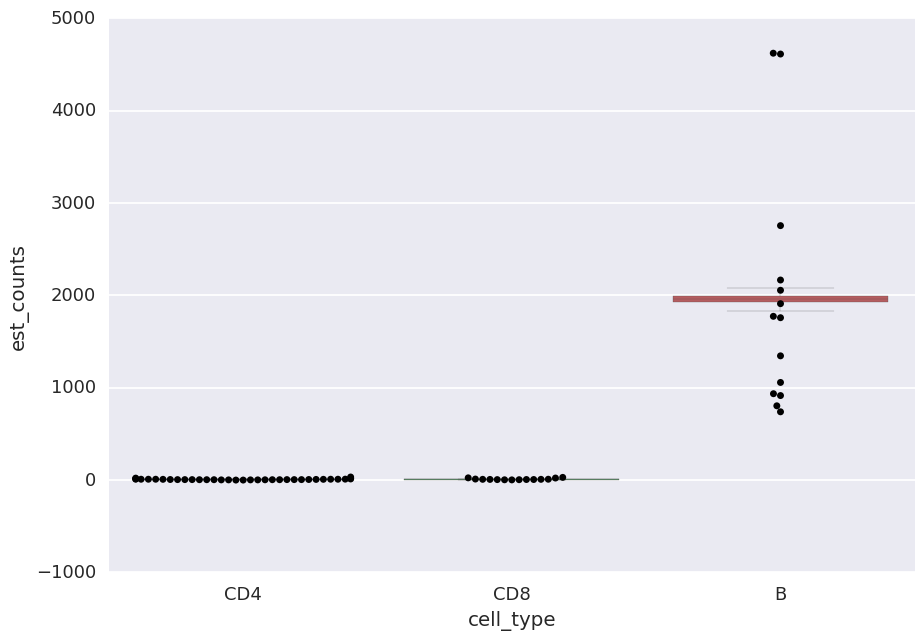

In [179]:
from matplotlib import pyplot as plt
sns.boxplot(data=yrep_df.query('gene_cat == "EBF1"'),
            x='cell_type',
            y='pp_est_counts',
            fliersize=0, linewidth=0.2)
sns.swarmplot(data=sample_df.loc[sample_df['gene_cat'] == "EBF1", :],
           x='cell_type',
           y='est_counts', color='black')

This is not great, since there is a lot more heterogeneity in these estimates than is enabled by the model.

We may want to try a different distribution than the poisson, or we may want to add a noise component to each transcript. 